# This is an analysis of the Employee case study :Capstone Project

### Things covered till now:
    * Created Table in the SQL.
    * Loaded tables in the HDFS using sqoop.
    * Created HIVE tables, data stored as PARQUET File.

### Initiatlizing sql context

In [6]:
from pyspark.sql import SQLContext
from pyspark import SparkContext
sc = SparkContext('local','Spark_session')
Sqlcontext = SQLContext(sc)

In [7]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### creating Dataframes of the individual Tables

In [8]:
departments = Sqlcontext.read.parquet("hdfs://nameservice1/user/anabig114233/capstone/warehouse/departments/d2c19c73-751c-445f-aaa7-0b15bf5adb6a.parquet")
departments.show(3)

+-------+-----------------+
|dept_no|        dept_name|
+-------+-----------------+
|   d001|      "Marketing"|
|   d002|        "Finance"|
|   d003|"Human Resources"|
+-------+-----------------+
only showing top 3 rows



In [9]:
dept_emp = Sqlcontext.read.parquet("hdfs://nameservice1/user/anabig114233/capstone/warehouse/dept_emp/a08fd6bb-124c-4d80-9eb4-bdf8d83c355e.parquet")
dept_emp.show(3)

+------+-------+
|emp_no|dept_no|
+------+-------+
| 10001|   d005|
| 10002|   d007|
| 10003|   d004|
+------+-------+
only showing top 3 rows



In [10]:
dept_manager = Sqlcontext.read.parquet("hdfs://nameservice1/user/anabig114233/capstone/warehouse/dept_manager/58e3a0c5-48e1-4817-bb5e-af2124039f3b.parquet")
dept_manager.show(3)

+-------+------+
|dept_no|emp_no|
+-------+------+
|   d001|110022|
|   d001|110039|
|   d002|110085|
+-------+------+
only showing top 3 rows



In [11]:
employees = Sqlcontext.read.parquet("hdfs://nameservice1/user/anabig114233/capstone/warehouse/employees/248b6afa-de10-45f3-89dc-78898dbbf5b3.parquet")
employees.show(3)

+------+------------+----------+----------+---------+---+----------+--------------+----------------+-----------+----------+
|emp_no|emp_title_id|birth_date|first_name|last_name|sex| hire_date|no_of_projects|Last_performance|left_status| last_date|
+------+------------+----------+----------+---------+---+----------+--------------+----------------+-----------+----------+
|
|
|
+------+------------+----------+----------+---------+---+----------+--------------+----------------+-----------+----------+
only showing top 3 rows



In [12]:
salaries = Sqlcontext.read.parquet("hdfs://nameservice1/user/anabig114233/capstone/warehouse/salaries/cfa42688-4dde-4298-ae00-81043feb31de.parquet")
salaries.show(3)

+------+------+
|emp_no|salary|
+------+------+
| 10001| 60117|
| 10002| 65828|
| 10003| 40006|
+------+------+
only showing top 3 rows



In [13]:
titles = Sqlcontext.read.parquet("hdfs://nameservice1/user/anabig114233/capstone/warehouse/titles/91e2b02b-42da-4213-85ef-a8524c7142b3.parquet")
titles.show(3)

+--------+------------------+
|title_id|             title|
+--------+------------------+
|   e0001|Assistant Engineer|
|   e0002|          Engineer|
|   e0003|   Senior Engineer|
+--------+------------------+
only showing top 3 rows



In [14]:
employees.printSchema()

root
 |-- emp_no: integer (nullable = true)
 |-- emp_title_id: string (nullable = true)
 |-- birth_date: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- hire_date: string (nullable = true)
 |-- no_of_projects: integer (nullable = true)
 |-- Last_performance: string (nullable = true)
 |-- left_status: string (nullable = true)
 |-- last_date: string (nullable = true)



### Removing double quotes in the dept_name column 

In [15]:
departments = departments.withColumn('dept_name', regexp_replace('dept_name', '"', ''))

In [16]:
departments.show()

+-------+------------------+
|dept_no|         dept_name|
+-------+------------------+
|   d001|         Marketing|
|   d002|           Finance|
|   d003|   Human Resources|
|   d004|        Production|
|   d005|       development|
|   d006|Quality Management|
|   d007|             Sales|
|   d008|          Research|
|   d009|  Customer Service|
+-------+------------------+



-------------------------------------------------------------------------------------------------------------------------

In [21]:
## we need to convert the date type columns in the employees table to date

employees = Sqlcontext.sql("""select emp_no,
emp_title_id,
TO_DATE(CAST(UNIX_TIMESTAMP(birth_date, 'MM/dd/yyyy') AS TIMESTAMP)) as birth_date,
first_name,
last_name,
sex,
TO_DATE(CAST(UNIX_TIMESTAMP(hire_date, 'MM/dd/yyyy') AS TIMESTAMP)) as hire_date,
no_of_projects,
Last_performance,
left_status,
TO_DATE(CAST(UNIX_TIMESTAMP(last_date, 'MM/dd/yyyy') AS TIMESTAMP)) as last_date
from employees
""")

employees.createOrReplaceTempView('employees')

In [22]:
## checking if transformed ??
Sqlcontext.sql("""select day(hire_date) from employees limit 3""").show()

+---------------------+
|dayofmonth(hire_date)|
+---------------------+
|                   26|
|                   21|
|                   28|
+---------------------+



### saving the temp view to query based on the dataframes crrated

In [20]:
departments.createOrReplaceTempView("departments")
dept_emp.createOrReplaceTempView("dept_emp")
dept_manager.createOrReplaceTempView("dept_manager")
employees.createOrReplaceTempView("employees")
salaries.createOrReplaceTempView("salaries")
titles.createOrReplaceTempView("titles")

In [160]:
 ## -------------- Basic EDA to check info about the DataFrames  ------------------------------------------------------

In [179]:
## What are the distinct departments??
Sqlcontext.sql("""select distinct dept_no from departments order by dept_no""").show()
## we have 9 distinct dept numbers


+-------+
|dept_no|
+-------+
|   d001|
|   d002|
|   d003|
|   d004|
|   d005|
|   d006|
|   d007|
|   d008|
|   d009|
+-------+



In [274]:
Sqlcontext.sql("""select distinct dept_name from departments """).show()
## Distinct department name

+------------------+
|         dept_name|
+------------------+
|             Sales|
|Quality Management|
|           Finance|
|        Production|
|          Research|
|  Customer Service|
|         Marketing|
|       development|
|   Human Resources|
+------------------+



In [184]:
## what are distinct titles available??

Sqlcontext.sql("""select title from titles""").show()

+------------------+
|             title|
+------------------+
|Assistant Engineer|
|          Engineer|
|   Senior Engineer|
|  Technique Leader|
|           Manager|
|             Staff|
|      Senior Staff|
+------------------+



In [189]:
## How many managers, how many employees??
Sqlcontext.sql("""select distinct emp_no from dept_manager""").count() ## 24 managers
Sqlcontext.sql("""select distinct emp_no from employees""").count() ## 300024 employees

300024

In [196]:
## First Date of Joining and Last date of Joining??
Sqlcontext.sql("""select MIN(hire_date) as first_joining from employees""").show()

Sqlcontext.sql("""select MAX(hire_date) as recent_joining from employees""").show()


+-------------+
|first_joining|
+-------------+
|   1985-01-01|
+-------------+

+--------------+
|recent_joining|
+--------------+
|    2000-01-28|
+--------------+



### Assignment Questions


#### A list showing employee number, last name, first name, sex, and salary for each employee1.
#### A list showing first name, last name, and hire date for employees who were hired in 1986.

------------------------------------------------------------------------------------------------------------------------------

In [202]:
Sqlcontext.sql("""select employees.emp_no, first_name, last_name, sex, salary from employees
join salaries on employees.emp_no = salaries.emp_no""").show()

+------+----------+-----------+---+------+
|emp_no|first_name|  last_name|sex|salary|
+------+----------+-----------+---+------+
| 10001|    Georgi|    Facello|  M| 60117|
| 10002|   Bezalel|     Simmel|  F| 65828|
| 10003|     Parto|    Bamford|  M| 40006|
| 10004| Chirstian|    Koblick|  M| 40054|
| 10005|   Kyoichi|   Maliniak|  M| 78228|
| 10006|    Anneke|    Preusig|  F| 40000|
| 10007|   Tzvetan|  Zielinski|  F| 56724|
| 10008|    Saniya|   Kalloufi|  M| 46671|
| 10009|    Sumant|       Peac|  F| 60929|
| 10010| Duangkaew|   Piveteau|  F| 72488|
| 10011|      Mary|      Sluis|  F| 42365|
| 10012|  Patricio|  Bridgland|  M| 40000|
| 10013| Eberhardt|     Terkki|  M| 40000|
| 10014|     Berni|      Genin|  M| 46168|
| 10015|  Guoxiang|  Nooteboom|  M| 40000|
| 10016|  Kazuhito|Cappelletti|  M| 70889|
| 10017| Cristinel|  Bouloucos|  F| 71380|
| 10018|  Kazuhide|       Peha|  F| 55881|
| 10019|   Lillian|    Haddadi|  M| 44276|
| 10020|    Mayuko|    Warwick|  M| 40000|
+------+---

In [211]:
Sqlcontext.sql(""" select first_name, last_name, hire_date from employees
where YEAR(hire_date) == 1986 """).show()

+----------+------------+----------+
|first_name|   last_name| hire_date|
+----------+------------+----------+
|    Georgi|     Facello|1986-06-26|
|     Parto|     Bamford|1986-08-28|
| Chirstian|     Koblick|1986-12-01|
|    Sanjiv|    Zschoche|1986-02-04|
|      Kwee|    Schusler|1986-02-26|
|   Kshitij|        Gils|1986-03-27|
|  Zhongwei|       Rosen|1986-10-30|
|   Xinglin|     Eugenio|1986-09-08|
| Sudharsan|Flasterstein|1986-08-12|
|    Kendra|     Hofting|1986-03-14|
|    Hilari|      Morton|1986-07-15|
|     Akemi|       Birch|1986-12-02|
|    Lunjin|      Giveon|1986-10-02|
|    Xuejia|      Ullian|1986-08-22|
|   Chikara|    Rissland|1986-01-23|
|  Domenick|    Peltason|1986-03-14|
|    Zissis|    Pintelas|1986-02-11|
|     Perry|   Shimshoni|1986-09-18|
|  Kazuhito| Encarnacion|1986-08-21|
|   Xiadong|       Perry|1986-11-05|
+----------+------------+----------+
only showing top 20 rows



#### A list showing the manager of each department with the following information: department number, department name, the manager's employee number, last name, first name.

----------------------------------------------------------------------------------------------------------------------------

In [275]:
Sqlcontext.sql("""select departments.dept_no,
departments.dept_name,
dept_manager.emp_no,
last_name,
first_name
from departments
join dept_manager
on departments.dept_no = dept_manager.dept_no
join employees
on  dept_manager.emp_no = employees.emp_no
""").show()  

+-------+------------------+------+------------+-----------+
|dept_no|         dept_name|emp_no|   last_name| first_name|
+-------+------------------+------+------------+-----------+
|   d001|         Marketing|110022|  Markovitch|  Margareta|
|   d001|         Marketing|110039|    Minakawa|   Vishwani|
|   d002|           Finance|110085|       Alpin|       Ebru|
|   d002|           Finance|110114|  Legleitner|      Isamu|
|   d003|   Human Resources|110183|Ossenbruggen|    Shirish|
|   d003|   Human Resources|110228|     Sigstam|    Karsten|
|   d004|        Production|110303|     Wegerle|  Krassimir|
|   d004|        Production|110344|       Cools|     Rosine|
|   d004|        Production|110386|      Kieras|       Shem|
|   d004|        Production|110420|    Ghazalie|      Oscar|
|   d005|       development|110511|    Hagimont|   DeForest|
|   d005|       development|110567|    DasSarma|       Leon|
|   d006|Quality Management|110725|     Onuegbe|  Peternela|
|   d006|Quality Managem

#### A list showing the department of each employee with the following information: employee number, last name, first name, and department name.

-------------------------------------------------------------------------------------------------------------------------------

In [276]:
Sqlcontext.sql(""" select
dept_emp.emp_no,
first_name,
last_name,
departments.dept_name
from departments
join dept_emp
on departments.dept_no = dept_emp.dept_no
join employees
on dept_emp.emp_no = employees.emp_no
""").show()

+------+----------+-----------+------------------+
|emp_no|first_name|  last_name|         dept_name|
+------+----------+-----------+------------------+
| 10001|    Georgi|    Facello|       development|
| 10002|   Bezalel|     Simmel|             Sales|
| 10003|     Parto|    Bamford|        Production|
| 10004| Chirstian|    Koblick|        Production|
| 10005|   Kyoichi|   Maliniak|   Human Resources|
| 10006|    Anneke|    Preusig|       development|
| 10007|   Tzvetan|  Zielinski|          Research|
| 10008|    Saniya|   Kalloufi|       development|
| 10009|    Sumant|       Peac|Quality Management|
| 10010| Duangkaew|   Piveteau|        Production|
| 10010| Duangkaew|   Piveteau|Quality Management|
| 10011|      Mary|      Sluis|  Customer Service|
| 10012|  Patricio|  Bridgland|       development|
| 10013| Eberhardt|     Terkki|   Human Resources|
| 10014|     Berni|      Genin|       development|
| 10015|  Guoxiang|  Nooteboom|          Research|
| 10016|  Kazuhito|Cappelletti|

#### A list showing first name, last name, and sex for employees whose first name is "Hercules" and last names begin with "B.“

In [229]:
Sqlcontext.sql(""" select 
first_name,
last_name,
sex
from employees
where first_name == "Hercules" and last_name LIKE "B%"
""").show()

+----------+-------------+---+
|first_name|    last_name|sex|
+----------+-------------+---+
|  Hercules|   Benzmuller|  M|
|  Hercules|      Brendel|  F|
|  Hercules|   Baranowski|  M|
|  Hercules|     Barreiro|  M|
|  Hercules|         Baer|  M|
|  Hercules|Bernardinello|  F|
|  Hercules|      Basagni|  M|
|  Hercules|        Biran|  F|
|  Hercules|    Bernatsky|  M|
|  Hercules|         Bail|  F|
|  Hercules|        Birge|  F|
|  Hercules|      Bisiani|  F|
|  Hercules|       Bodoff|  M|
|  Hercules|        Biron|  F|
|  Hercules|      Buchter|  M|
|  Hercules|         Bain|  F|
|  Hercules|         Bahr|  M|
|  Hercules|         Baak|  M|
|  Hercules|     Benantar|  F|
|  Hercules|      Berstel|  F|
+----------+-------------+---+



#### A list showing all employees in the Sales department, including their employee number, last name, first name, and department name.

In [277]:
Sqlcontext.sql("""select
dept_emp.emp_no,
first_name,
last_name,
departments.dept_name
from departments
join dept_emp
on departments.dept_no = dept_emp.dept_no
join employees
on dept_emp.emp_no = employees.emp_no
where dept_name == 'Sales'
""").show()

+------+----------+------------+---------+
|emp_no|first_name|   last_name|dept_name|
+------+----------+------------+---------+
| 10002|   Bezalel|      Simmel|    Sales|
| 10016|  Kazuhito| Cappelletti|    Sales|
| 10034|     Bader|        Swan|    Sales|
| 10041|       Uri|      Lenart|    Sales|
| 10050|   Yinghua|      Dredge|    Sales|
| 10053|    Sanjiv|    Zschoche|    Sales|
| 10060|  Breannda| Billingsley|    Sales|
| 10061|       Tse|      Herber|    Sales|
| 10068|  Charlene|     Brattka|    Sales|
| 10087|   Xinglin|     Eugenio|    Sales|
| 10088|  Jungsoon|    Syrzycki|    Sales|
| 10089| Sudharsan|Flasterstein|    Sales|
| 10093|   Sailaja|     Desikan|    Sales|
| 10095|    Hilari|      Morton|    Sales|
| 10099|    Valter|     Sullins|    Sales|
| 10101|     Perla|      Heyers|    Sales|
| 10107|      Dung|        Baca|    Sales|
| 10125|     Syozo|     Hiltgen|    Sales|
| 10136|    Zissis|    Pintelas|    Sales|
| 10148|    Douadi|       Azumi|    Sales|
+------+---

#### A list showing all employees in the Sales and Development departments, including their employee number, last name, first name, and department name

----------------------------------------------------------------------------------------------------------------------------

In [280]:
Sqlcontext.sql("""select
dept_emp.emp_no,
first_name,
last_name,
departments.dept_name
from departments
join dept_emp
on departments.dept_no = dept_emp.dept_no
join employees
on dept_emp.emp_no = employees.emp_no
where dept_name == 'Sales' or dept_name == "development"
""").show()

+------+----------+-----------+-----------+
|emp_no|first_name|  last_name|  dept_name|
+------+----------+-----------+-----------+
| 10001|    Georgi|    Facello|development|
| 10002|   Bezalel|     Simmel|      Sales|
| 10006|    Anneke|    Preusig|development|
| 10008|    Saniya|   Kalloufi|development|
| 10012|  Patricio|  Bridgland|development|
| 10014|     Berni|      Genin|development|
| 10016|  Kazuhito|Cappelletti|      Sales|
| 10018|  Kazuhide|       Peha|development|
| 10021|     Ramzi|       Erde|development|
| 10022|    Shahaf|     Famili|development|
| 10023|     Bojan| Montemayor|development|
| 10025| Prasadram|     Heyers|development|
| 10027|    Divier|    Reistad|development|
| 10028|  Domenick|   Tempesti|development|
| 10031|   Karsten|     Joslin|development|
| 10034|     Bader|       Swan|      Sales|
| 10037|   Pradeep|   Makrucki|development|
| 10040|     Weiyi|    Meriste|development|
| 10041|       Uri|     Lenart|      Sales|
| 10043|    Yishay|    Tzvieli|d

### A list showing the frequency count of employee last names, in descending order. ( i.e., how many employees share each last name

----------------------------------------------------------------------------------------------------------------------------

In [301]:
Sqlcontext.sql("""
select last_name,
COUNT(emp_no) as count
from employees
group by last_name
order by count desc

""").show()

+-----------+-----+
|  last_name|count|
+-----------+-----+
|       Baba|  226|
|     Gelosh|  223|
|      Coorg|  223|
|    Sudbeck|  222|
|     Farris|  222|
|     Adachi|  221|
|     Osgood|  220|
|     Neiman|  218|
|    Mandell|  218|
|     Masada|  218|
|Boudaillier|  217|
|    Wendorf|  217|
|     Mahnke|  216|
|    Solares|  216|
|     Pettis|  216|
|   Cummings|  216|
|     Emmart|  215|
|    Kulisch|  215|
|   Birjandi|  215|
| Maksimenko|  215|
+-----------+-----+
only showing top 20 rows



### Histogram to show the salary distribution among the employees

In [302]:
salary = Sqlcontext.sql("""
select salary
from salaries
""").toPandas()

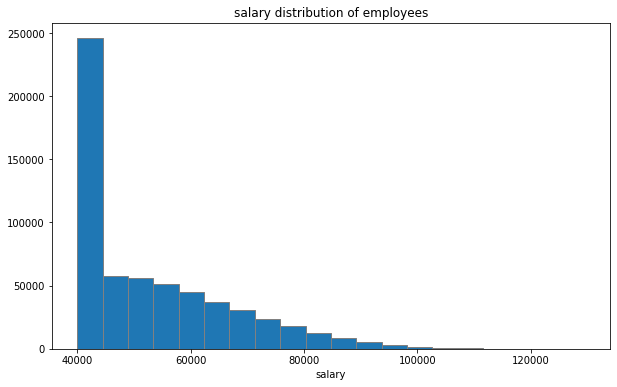

In [319]:
fig, axes = plt.subplots(figsize = (10, 6))
plt.hist(salary['salary'], bins = 20, edgecolor = 'gray')
plt.title("salary distribution of employees")
plt.xlabel("salary")
plt.show()

### Bar graph to show the Average salary per title (designation)

In [334]:
Sqlcontext.sql("""select distinct
emp_title_id from employees

""").show()

+------------+
|emp_title_id|
+------------+
|       e0004|
|       e0003|
|       s0001|
|       m0001|
|       e0001|
|       e0002|
|       s0002|
+------------+



In [337]:
Sqlcontext.sql("""select distinct title_id from  from titles""").show()

+-----+
| from|
+-----+
|e0004|
|e0003|
|s0001|
|m0001|
|e0001|
|e0002|
|s0002|
+-----+



## unable to perform the join??

In [328]:
Sqlcontext.sql("""select title_id, title from titles""").show()

+--------+------------------+
|title_id|             title|
+--------+------------------+
|   e0001|Assistant Engineer|
|   e0002|          Engineer|
|   e0003|   Senior Engineer|
|   e0004|  Technique Leader|
|   m0001|           Manager|
|   s0001|             Staff|
|   s0002|      Senior Staff|
+--------+------------------+



### Calculate employee tenure & show the tenure distribution among the employees

In [357]:
year_tenure = Sqlcontext.sql("""select floor(months_between(last_date, hire_date)/12) AS tenure_in_years from employees""")
tenure_dist = year_tenure.filter("tenure_in_years is not null")
tenure_dist.createOrReplaceTempView("tenure_dist")

In [363]:
tenure_dist = tenure_dist.toPandas()

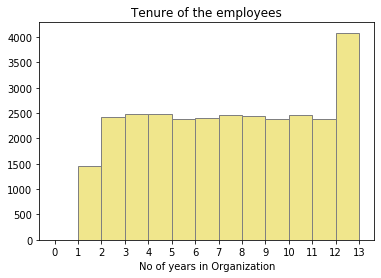

In [396]:

plt.hist(tenure_dist['tenure_in_years'], bins = range(14), color = 'khaki', edgecolor = 'gray')
plt.xticks(range(14))
plt.xlabel("No of years in Organization")
plt.title("Tenure of the employees")
plt.show()

### Resignations across the years, Is there any trend observed in Resignations 

In [403]:
resignations = Sqlcontext.sql("""select
YEAR(last_date) as financial_year,
COUNT(emp_no) as employees
from employees
where last_date is not null
group by financial_year
order by financial_year""").toPandas()


Text(0.5, 1.0, 'Resignations distribution across the years')

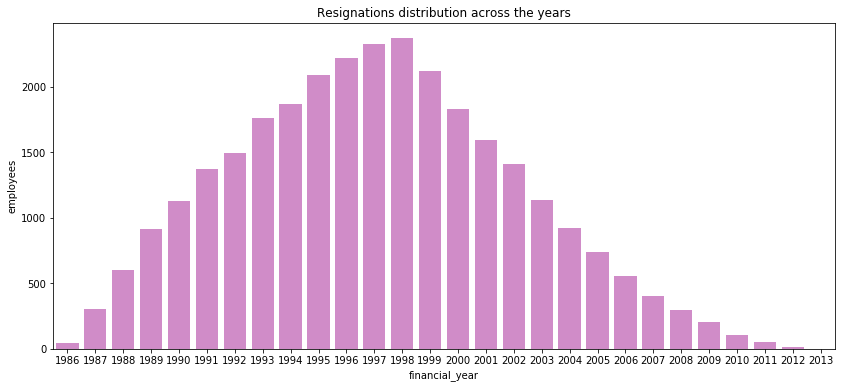

In [408]:
plt.figure(figsize = (14, 6))
sns.barplot(data = resignations, x = 'financial_year', y= 'employees', color = '#DB81D1')
plt.title("Resignations distribution across the years")

## we can observe that the resignations slowed down post 1998, might be attributed to good company retention policies

----------------------------------------------------------------------------------------------------------------------------

### which departments saw highest resignation within the timeline i.e. 1992 -1998 or was it equal for all?



In [435]:
selective_resignation = Sqlcontext.sql("""select
YEAR(last_date) as financial_year,
dept_name,
COUNT(employees.emp_no) as employees
from employees
join dept_emp
on dept_emp.emp_no = employees.emp_no
join departments
on dept_emp.dept_no = departments.dept_no
where last_date is not null
and YEAR(last_date) BETWEEN 1992 AND 1998
group by 1, 2
order by 1 , 3 desc"""
)

In [422]:
selective_resignation.show()

+--------------+------------------+---------+
|financial_year|         dept_name|employees|
+--------------+------------------+---------+
|          1992|       development|      434|
|          1992|        Production|      352|
|          1992|             Sales|      246|
|          1992|  Customer Service|      127|
|          1992|Quality Management|      115|
|          1992|          Research|      103|
|          1992|   Human Resources|      102|
|          1992|         Marketing|       90|
|          1992|           Finance|       71|
|          1993|       development|      497|
|          1993|        Production|      432|
|          1993|             Sales|      304|
|          1993|  Customer Service|      147|
|          1993|         Marketing|      133|
|          1993|Quality Management|      125|
|          1993|          Research|      116|
|          1993|   Human Resources|       98|
|          1993|           Finance|       95|
|          1994|       development

#### Finding the top 2 for all these years

In [436]:
windowSpec  = Window.partitionBy("financial_year").orderBy(desc("employees"))

resignation_trend = selective_resignation.withColumn("row_number", row_number().over(windowSpec))

In [446]:
resignation_trend.filter("row_number in (1, 2)").show()
## we can see the maximum resignation aross all these years have been witnessed in

## 1.st development and second in Production

+--------------+-----------+---------+----------+
|financial_year|  dept_name|employees|row_number|
+--------------+-----------+---------+----------+
|          1997|development|      685|         1|
|          1997| Production|      625|         2|
|          1994|development|      531|         1|
|          1994| Production|      439|         2|
|          1996|development|      632|         1|
|          1996| Production|      523|         2|
|          1998|development|      677|         1|
|          1998| Production|      563|         2|
|          1995|development|      623|         1|
|          1995| Production|      531|         2|
|          1992|development|      434|         1|
|          1992| Production|      352|         2|
|          1993|development|      497|         1|
|          1993| Production|      432|         2|
+--------------+-----------+---------+----------+



#### Now also major contributor to the people leaving is from development and production but numbers have drastically reduced

## Resignation trends across all these years across all departments

In [480]:
all_resignations = Sqlcontext.sql("""select
YEAR(last_date) as financial_year,
dept_name,
COUNT(employees.emp_no) as employees
from employees
join dept_emp
on dept_emp.emp_no = employees.emp_no
join departments
on dept_emp.dept_no = departments.dept_no
where last_date is not null
group by 1, 2
order by 1 , 3 desc"""
).toPandas()



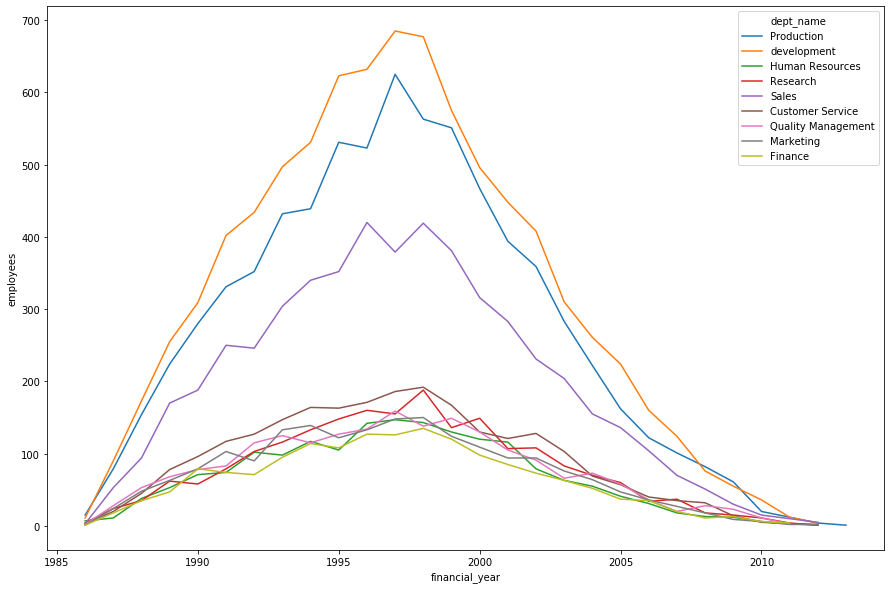

In [487]:
plt.figure(figsize = (15, 10))
sns.lineplot(data = all_resignations, x = 'financial_year', y= 'employees', hue = 'dept_name')
plt.show()

### Is there any disparity in terms of project assignemnent amongst genders (M/F)?

In [495]:
Sqlcontext.sql("""select
sex,
round((SUM(no_of_projects)/COUNT(emp_no)), 2) as mean_project_rate,
SUM(no_of_projects) as projects
from employees
group by sex""").show()

## Male are females are given same projects all these years showcasing gender parity in the organization

+---+-----------------+--------+
|sex|mean_project_rate|projects|
+---+-----------------+--------+
|  F|              5.5|  660229|
|  M|             5.51|  991351|
+---+-----------------+--------+



### Is there any particular department having gender based segregation?

In [499]:
Sqlcontext.sql("""select
sex,
dept_name,
COUNT(employees.emp_no) as no_of_employees
from departments
join dept_emp
on departments.dept_no = dept_emp.dept_no
join employees
on employees. emp_no = dept_emp.emp_no
group by 1, 2
""").show()

+---+------------------+---------------+
|sex|         dept_name|no_of_employees|
+---+------------------+---------------+
|  M|         Marketing|          12174|
|  M|  Customer Service|          14132|
|  M|Quality Management|          12039|
|  F|         Marketing|           8037|
|  F|Quality Management|           8078|
|  F|  Customer Service|           9448|
|  F|   Human Resources|           7075|
|  F|          Research|           8439|
|  M|          Research|          12687|
|  M|       development|          51449|
|  M|        Production|          43936|
|  F|           Finance|           7015|
|  F|             Sales|          20854|
|  F|        Production|          29549|
|  M|   Human Resources|          10711|
|  M|             Sales|          31391|
|  M|           Finance|          10331|
|  F|       development|          34258|
+---+------------------+---------------+



In [507]:
gender_seg = Sqlcontext.sql("""select
sex,
dept_name,
COUNT(employees.emp_no) as no_of_employees
from departments
join dept_emp
on departments.dept_no = dept_emp.dept_no
join employees
on employees. emp_no = dept_emp.emp_no
group by 1, 2
""").toPandas()

In [530]:
Sqlcontext.sql("select distinct dept_name from departments").show()

+------------------+
|         dept_name|
+------------------+
|             Sales|
|Quality Management|
|           Finance|
|        Production|
|          Research|
|  Customer Service|
|         Marketing|
|       development|
|   Human Resources|
+------------------+



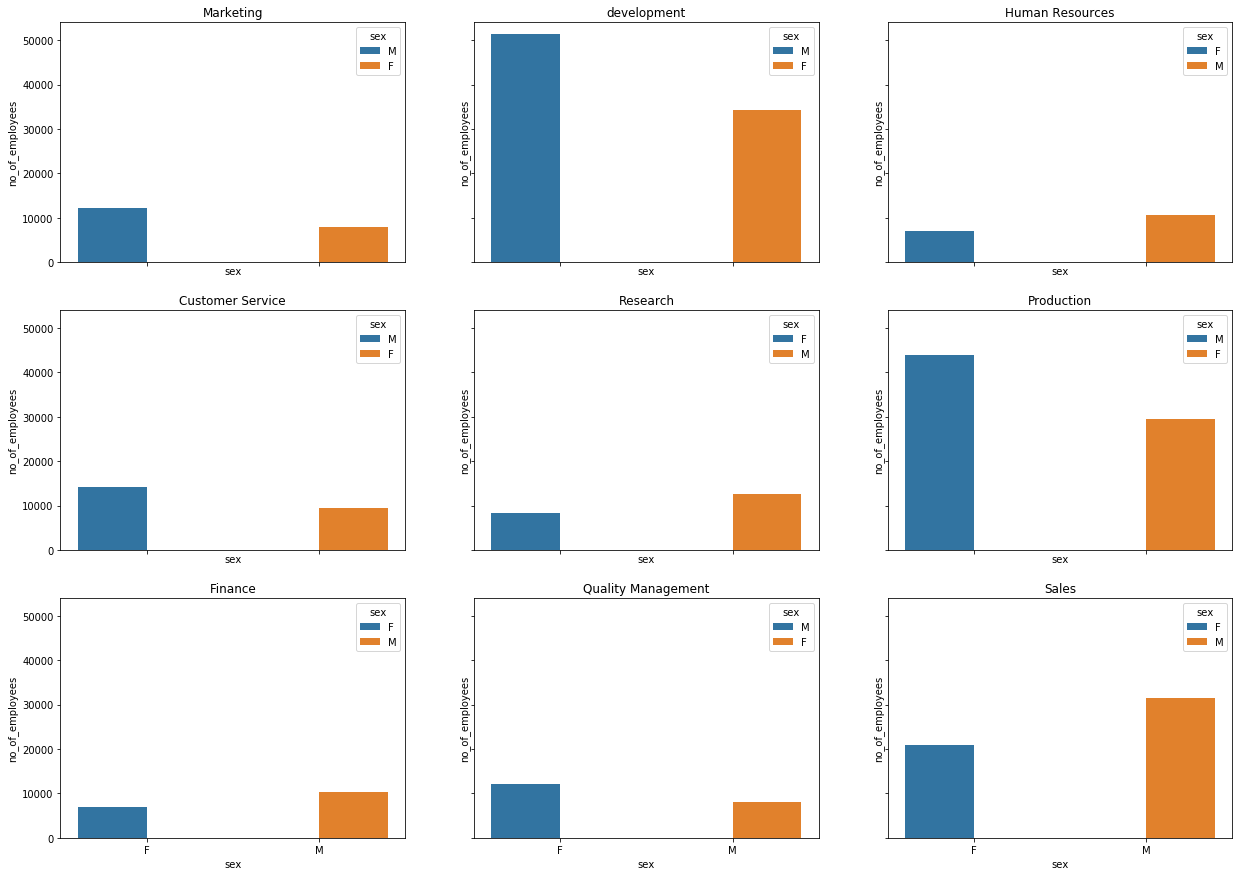

In [537]:
fig, ax = plt.subplots(3,3, sharex = True, sharey= True, figsize = (21, 15))

ax1 = sns.barplot(data = gender_seg[gender_seg['dept_name'] == 'Marketing'], x = 'sex',
            y ='no_of_employees', ax = ax[0,0], hue = 'sex')
ax1.title.set_text('Marketing')


ax2 = sns.barplot(data = gender_seg[gender_seg['dept_name'] == 'development'], x = 'sex',
            y ='no_of_employees', ax = ax[0,1], hue = 'sex')
ax2.title.set_text('development')


ax3 = sns.barplot(data = gender_seg[gender_seg['dept_name'] == 'Human Resources'], x = 'sex',
            y ='no_of_employees', ax = ax[0,2], hue = 'sex')
ax3.title.set_text('Human Resources')



ax4 = sns.barplot(data = gender_seg[gender_seg['dept_name'] == 'Customer Service'], x = 'sex',
            y ='no_of_employees', ax = ax[1,0], hue = 'sex')
ax4.title.set_text('Customer Service')


ax5 = sns.barplot(data = gender_seg[gender_seg['dept_name'] == 'Research'], x = 'sex',
            y ='no_of_employees', ax = ax[1,1], hue = 'sex')
ax5.title.set_text('Research')


ax6 = sns.barplot(data = gender_seg[gender_seg['dept_name'] == 'Production'], x = 'sex',
            y ='no_of_employees', ax = ax[1,2], hue = 'sex')
ax6.title.set_text('Production')


ax7 = sns.barplot(data = gender_seg[gender_seg['dept_name'] == 'Finance'], x = 'sex',
            y ='no_of_employees', ax = ax[2,0], hue = 'sex')
ax7.title.set_text('Finance')


ax8 = sns.barplot(data = gender_seg[gender_seg['dept_name'] == 'Quality Management'], x = 'sex',
            y ='no_of_employees', ax = ax[2,1], hue = 'sex')
ax8.title.set_text('Quality Management')


ax9 = sns.barplot(data = gender_seg[gender_seg['dept_name'] == 'Sales'], x = 'sex',
            y ='no_of_employees', ax = ax[2,2], hue = 'sex')
ax9.title.set_text('Sales')


plt.savefig("gender_dep")
plt.show()


In [ ]:
## notecable skewness in gender divide across three departments i.e. Sales, production, and development 

## Salary distribution across titles

In [33]:
Sqlcontext.sql("""
select title,
round((SUM(salary)/COUNT(salaries.emp_no)), 0) as mean_salary
from salaries
join employees
on salaries.emp_no = employees.emp_no
join titles
on employees.emp_title_id = titles.title_id
group by title
order by 2 desc

""").show()

+------------------+-----------+
|             title|mean_salary|
+------------------+-----------+
|      Senior Staff|    58550.0|
|             Staff|    58465.0|
|           Manager|    51531.0|
|  Technique Leader|    48583.0|
|Assistant Engineer|    48564.0|
|          Engineer|    48535.0|
|   Senior Engineer|    48507.0|
+------------------+-----------+



#### Highest salary is seen for Senior Staff

-----------------------------------------------------------------------------------------------------------------------------

In [36]:
Sqlcontext.sql("""select year(max(hire_date)) from employees""").show()

## Current Year (Present Year)

+--------------------+
|year(max(hire_date))|
+--------------------+
|                2000|
+--------------------+



### Who all are managers right now? what department they are serving, and how many people of team they are leading at present

In [62]:
Sqlcontext.sql("""select
dept_name,
dept_manager.emp_no as manager_code,
COUNT(dept_emp.emp_no) as no_of_employees
from dept_manager
join dept_emp
on dept_manager.dept_no = dept_emp.dept_no
join departments
on dept_emp.dept_no = departments.dept_no
group by 1,2
order by 3 desc

""").createOrReplaceTempView("manager_team_count")

In [67]:
Sqlcontext.sql("""select
dept_name,
first_name,
last_name,
no_of_employees
from manager_team_count
join employees
on manager_team_count.manager_code = employees.emp_no
where left_status = '0'
""").show()

+------------------+-----------+-----------+---------------+
|         dept_name| first_name|  last_name|no_of_employees|
+------------------+-----------+-----------+---------------+
|       development|       Leon|   DasSarma|          85707|
|       development|   DeForest|   Hagimont|          85707|
|        Production|  Krassimir|    Wegerle|          73485|
|        Production|     Rosine|      Cools|          73485|
|        Production|      Oscar|   Ghazalie|          73485|
|        Production|       Shem|     Kieras|          73485|
|             Sales|      Hauke|      Zhang|          52245|
|             Sales|Przemyslawa|  Kaelbling|          52245|
|  Customer Service|    Xiaobin|   Spinelli|          23580|
|  Customer Service|      Marjo| Giarratana|          23580|
|  Customer Service|      Tonny|Butterworth|          23580|
|  Customer Service|    Yuchang|    Weedman|          23580|
|          Research|       Arie|    Staelin|          21126|
|          Research|    

In [70]:
## Out of 24 originally reported managers 2 managers left the organization

Sqlcontext.sql("""select
dept_name,
first_name,
last_name,
no_of_employees
from manager_team_count
join employees
on manager_team_count.manager_code = employees.emp_no
where left_status = '1'
""").show()

+------------------+----------+----------+---------------+
|         dept_name|first_name| last_name|no_of_employees|
+------------------+----------+----------+---------------+
|Quality Management| Peternela|   Onuegbe|          20117|
|           Finance|     Isamu|Legleitner|          17346|
+------------------+----------+----------+---------------+



#### ---------------------------------------------------------------------------------------------------------------------------------------- submitted by: Lokesh Bhatt